In [5]:
!pip install pandas scikit-learn Sastrawi matplotlib seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [6]:
import pandas as pd
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# --- 1. MEMUAT DAN MEMBERI LABEL PADA DATA ---
print("Langkah 1: Memuat dan Melabeli Data...")

try:
    # Memuat data dari file CSV yang diunggah
    # Pastikan file 'tweets.csv' ada di direktori yang sama
    tweets_df = pd.read_csv('tweets.csv')
except FileNotFoundError:
    print("Error: Pastikan file 'tweets.csv' berada di direktori yang sama dengan skrip ini.")
    exit()

# Mengambil kolom 'text' dan memfilter hanya yang mengandung kata 'banjir'
tweets_df = tweets_df[['text']].dropna()
tweets_df = tweets_df[tweets_df['text'].str.contains('banjir', case=False)].copy()

def label_konteks(text):
    """Memberi label pada teks berdasarkan kata kunci untuk konteks 'bencana' atau 'metafora'."""
    text_lower = text.lower()

    # Kata kunci untuk konteks BENCANA ALAM
    konteks_bencana = ['rob', 'rumah', 'warga', 'kabupaten', 'terendam', 'panen', 'kekeringan', 'dampak', 'gagal panen', 'melanda']

    # Kata kunci untuk konteks METAFORA
    konteks_metafora = ['orderan', 'ompol', 'nangis', 'win', 'au angst', 'joki', 'cuan', 'drh' , 'darah', 'air mata']

    if any(keyword in text_lower for keyword in konteks_bencana):
        return 'bencana'
    if any(keyword in text_lower for keyword in konteks_metafora):
        return 'metafora'

    return 'tidak terdefinisi'

# Menerapkan fungsi pelabelan dan membuang yang tidak terdefinisi
tweets_df['konteks'] = tweets_df['text'].apply(label_konteks)
labeled_df = tweets_df[tweets_df['konteks'] != 'tidak terdefinisi'].copy()

print(f"\nTotal tweet ditemukan: {len(tweets_df)}")
print(f"Total tweet yang berhasil dilabeli: {len(labeled_df)}")
print("\nDistribusi Konteks:")
print(labeled_df['konteks'].value_counts())

Langkah 1: Memuat dan Melabeli Data...

Total tweet ditemukan: 4980
Total tweet yang berhasil dilabeli: 1558

Distribusi Konteks:
konteks
metafora    955
bencana     603
Name: count, dtype: int64


In [8]:
# --- 2. DATA PREPARATION (CLEANING & STEMMING) ---
print("\nLangkah 2: Membersihkan dan Melakukan Stemming Teks...")

# Inisialisasi stemmer Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def preprocess_text(text):
    """Fungsi untuk membersihkan teks dan mengubahnya ke bentuk dasar (stemming)."""
    text = text.lower()  # Mengubah ke huruf kecil
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Menghilangkan URL
    text = re.sub(r'\@\w+|\#','', text) # Menghilangkan mention dan hashtag
    text = re.sub(r'[^a-z\s]', '', text) # Menghilangkan karakter non-alfabet
    text = stemmer.stem(text) # Mengubah kata ke bentuk dasar
    return text

# Menerapkan fungsi pra-pemrosesan
labeled_df['cleaned_text'] = labeled_df['text'].apply(preprocess_text)

print("\nContoh hasil data preparation:")
print(labeled_df[['cleaned_text', 'konteks']].head().to_string())



Langkah 2: Membersihkan dan Melakukan Stemming Teks...

Contoh hasil data preparation:
                                                                                                                                                                                                                                                                 cleaned_text   konteks
4                                                                                                                                                                                                                                  belum syuting aja dah liat banjir air mata  metafora
10                                                                                                                                                                                                                    udh banjir sekitar by kyk bekas pas hujan krna air mata  metafora
23                                                                      

In [9]:
# --- 3. PEMBUATAN & PELATIHAN MODEL ---
print("\nLangkah 3: Membagi Data, Ekstraksi Fitur TF-IDF, dan Melatih Model...")

# Memisahkan data menjadi fitur (X) dan target (y)
X = labeled_df['cleaned_text']
y = labeled_df['konteks']

# Membagi data menjadi data latih (80%) dan data uji (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Membuat pipeline yang menggabungkan TF-IDF dan model Regresi Logistik
text_classification_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),  # Menggunakan unigram & bigram
    ('clf', LogisticRegression(random_state=42, C=1.0, solver='liblinear')),
])

# Melatih model menggunakan data latih
text_classification_pipeline.fit(X_train, y_train)
print("\nModel berhasil dilatih.")


Langkah 3: Membagi Data, Ekstraksi Fitur TF-IDF, dan Melatih Model...

Model berhasil dilatih.



Langkah 4: Mengevaluasi Kinerja Model...

Laporan Klasifikasi Model:
              precision    recall  f1-score   support

     bencana       0.98      0.91      0.94       121
    metafora       0.94      0.99      0.97       191

    accuracy                           0.96       312
   macro avg       0.96      0.95      0.96       312
weighted avg       0.96      0.96      0.96       312



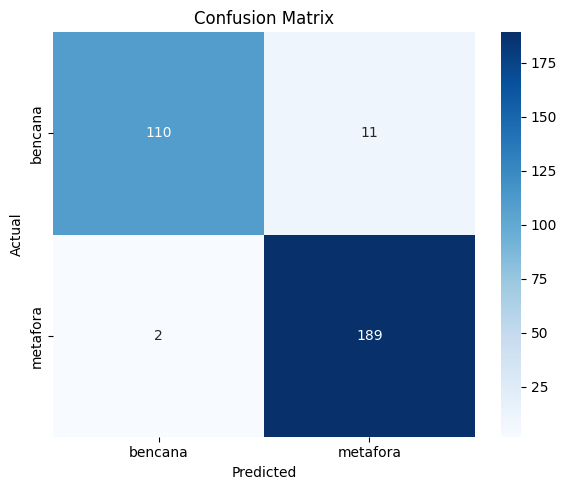

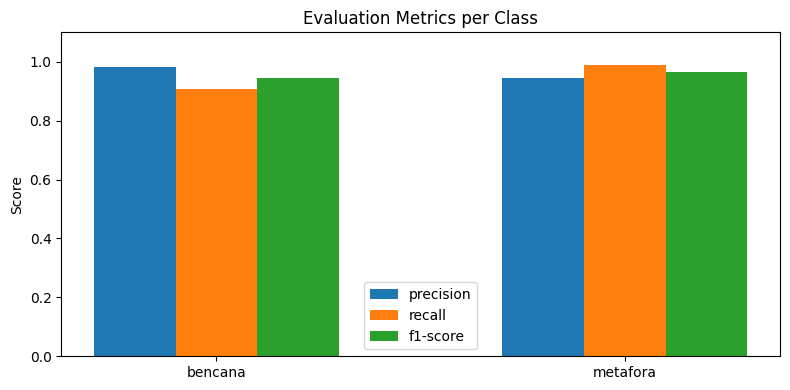

In [11]:
# --- 4. EVALUASI MODEL ---
print("\nLangkah 4: Mengevaluasi Kinerja Model...")

# Memprediksi label untuk data uji
y_pred = text_classification_pipeline.predict(X_test)

# Menampilkan laporan klasifikasi (precision, recall, f1-score)
print("\nLaporan Klasifikasi Model:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=text_classification_pipeline.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=text_classification_pipeline.classes_,
            yticklabels=text_classification_pipeline.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

print("\n")

# Plot precision, recall, F1-score per class
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(8, 4))
metrics = ['precision', 'recall', 'f1-score']
bar_width = 0.2
for i, metric in enumerate(metrics):
    values = [report_df.loc[label, metric] for label in text_classification_pipeline.classes_]
    positions = [x + i * bar_width for x in range(len(values))]
    plt.bar(positions, values, width=bar_width, label=metric)

plt.xticks([r + bar_width for r in range(len(values))], text_classification_pipeline.classes_)
plt.ylim(0, 1.1)
plt.legend()
plt.title("Evaluation Metrics per Class")
plt.ylabel("Score")
plt.tight_layout()
plt.show()


In [14]:
# --- 5. MENGGUNAKAN MODEL UNTUK PREDIKSI BARU ---
print("\nLangkah 5: Menggunakan Model untuk Memprediksi Tweet Baru...")

# Siapkan beberapa contoh tweet baru
tweet_baru = [
    "Selamat! Semoga usahanya makin sukses dan banjir orderan!",
    "Dilaporkan banjir bandang kembali melanda beberapa desa di kabupaten itu.",
    "Aku nangis sampe banjir air mata nonton dramanya.",
    "Banjir rob merendam ratusan rumah warga di kawasan pesisir."
]

# Lakukan prediksi pada tweet baru
prediksi_baru = text_classification_pipeline.predict(tweet_baru)
prediksi_proba = text_classification_pipeline.predict_proba(tweet_baru)

# Tampilkan hasil prediksi
print("\nHasil Prediksi:")
for i, tweet in enumerate(tweet_baru):
    konteks_terprediksi = prediksi_baru[i]
    # Mencari probabilitas untuk kelas yang diprediksi
    kelas_index = list(text_classification_pipeline.classes_).index(konteks_terprediksi)
    probabilitas = prediksi_proba[i][kelas_index]

    print(f'-> Tweet: "{tweet}"')
    print(f'   Prediksi Konteks: {konteks_terprediksi.upper()} (Probabilitas: {probabilitas:.2%})\n')



Langkah 5: Menggunakan Model untuk Memprediksi Tweet Baru...

Hasil Prediksi:
-> Tweet: "Selamat! Semoga usahanya makin sukses dan banjir orderan!"
   Prediksi Konteks: METAFORA (Probabilitas: 56.42%)

-> Tweet: "Dilaporkan banjir bandang kembali melanda beberapa desa di kabupaten itu."
   Prediksi Konteks: BENCANA (Probabilitas: 73.56%)

-> Tweet: "Aku nangis sampe banjir air mata nonton dramanya."
   Prediksi Konteks: METAFORA (Probabilitas: 99.02%)

-> Tweet: "Banjir rob merendam ratusan rumah warga di kawasan pesisir."
   Prediksi Konteks: BENCANA (Probabilitas: 94.88%)



In [15]:
import joblib

# Simpan pipeline model
joblib.dump(text_classification_pipeline, '../flood_tweet_model.pkl')
print("Model disimpan ke flood_tweet_model.pkl")

Model disimpan ke flood_tweet_model.pkl
